In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

***Data Import!***

In [2]:
imputed_data = pd.read_csv('data/imputed_data.csv')
# Check the first few rows to verify the structure
imputed_data.head()

,Name,Position,College,Round,Pick,Stat URL,Height,Weight,40 Yard Dash,Bench Press,...,rec_td,rush_att,rush_yds,rush_yds_per_att,rush_td,scrim_att,scrim_yds,scrim_yds_per_att,scrim_td,Year
0,Emmanuel Acho,OLB,Texas,6,204,https://www.sports-reference.com/cfb/players/e...,74.0,238.0,4.64,24.00,...,5.29,199.20,1282.58,8.83,14.91,239.71,1747.91,8.22,20.20,2012
1,Joe Adams,WR,Arkansas,4,104,https://www.sports-reference.com/cfb/players/j...,71.0,179.0,4.51,14.59,...,8.50,4.00,69.50,11.65,0.00,96.00,1393.50,14.45,8.50,2012
2,Chas Alecxih,DT,Pittsburgh,0,0,https://www.sports-reference.com/cfb/players/c...,76.0,296.0,5.31,19.00,...,0.00,1.19,5.20,-0.68,0.36,1.36,5.55,0.86,0.36,2012
3,Frank Alexander,DE,Oklahoma,4,103,https://www.sports-reference.com/cfb/players/f...,76.0,270.0,4.80,24.48,...,2.17,22.98,75.37,4.12,4.24,36.81,231.59,6.49,6.41,2012
4,Antonio Allen,S,South Carolina,7,242,https://www.sports-reference.com/cfb/players/a...,73.0,210.0,4.58,17.00,...,1.68,374.69,2061.25,4.94,19.21,420.39,2397.36,6.43,20.89,2012


***Feature Selection from the Data!***

In [3]:
# Re-importing required libraries for feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import LabelEncoder

In [4]:
# Preparing the data
# Using 'Round' as the target variable, as it indicates if and when a player was selected
X = imputed_data.select_dtypes(include=['float64', 'int64']).drop(columns=['Round'], errors='ignore')
y = imputed_data['Round']

In [5]:
# Encoding the target variable (Round) for classification
y_encoded = LabelEncoder().fit_transform(y)

In [6]:
# Applying mutual information for feature selection (useful for classification problems)
selector = SelectKBest(mutual_info_classif, k=5)  # Top 5 features for simplicity
selector.fit(X, y_encoded)

SelectKBest(k=5,
            score_func=<function mutual_info_classif at 0x00000195BE664E00>)

In [7]:
# Get the selected features
selected_features = X.columns[selector.get_support(indices=True)]
selected_features

Index(['Pick', 'seasons', 'rush_yds_per_att', 'scrim_att', 'Year'], dtype='object')

***SCM using the features & DoWhy PY Library!***

In [8]:
# Importing DoWhy for structural causal model creation
from dowhy import CausalModel

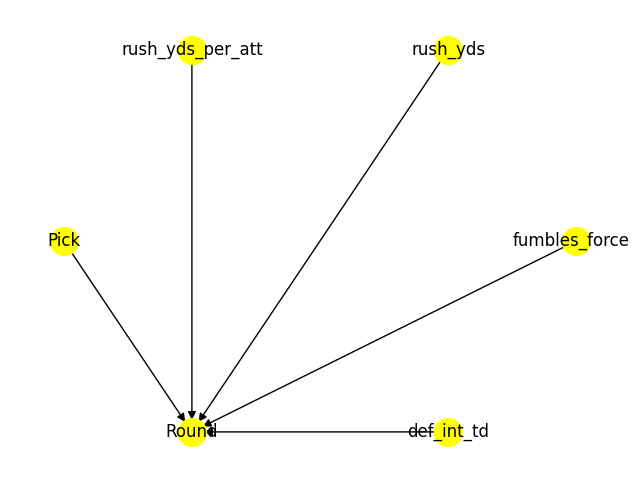

In [9]:
# Subset data with selected features
scm_data = imputed_data[['Pick', 'def_int_td', 'fumbles_forced', 'rush_yds', 'rush_yds_per_att', 'Round']]

# Define the causal graph in DoWhy format
# Using assumptions based on typical relationships in NFL draft data
causal_graph = """
digraph {
    Pick -> Round;
    def_int_td -> Round;
    fumbles_forced -> Round;
    rush_yds -> Round;
    rush_yds_per_att -> Round;
}
"""

# Creating the Causal Model
causal_model = CausalModel(
    data=scm_data,
    treatment="Pick",  # Treat 'Pick' as the primary feature for interventions
    outcome="Round",
    graph=causal_graph
)

# Visualize the causal graph
causal_model.view_model(layout="dot")

***Alternate Viz Using NetworkX!***

In [11]:
# Create a directed graph
G = nx.DiGraph()

In [12]:
# Add nodes based on selected features and target variable
nodes = ["Pick", "def_int_td", "fumbles_forced", "rush_yds", "rush_yds_per_att", "Round"]
G.add_nodes_from(nodes)

In [13]:
# Define causal edges based on hypothesized relationships
edges = [
    ("Pick", "Round"),
    ("def_int_td", "Round"),
    ("fumbles_forced", "Round"),
    ("rush_yds", "Round"),
    ("rush_yds_per_att", "Round")
]

In [14]:
# Add directed edges to the graph
G.add_edges_from(edges)

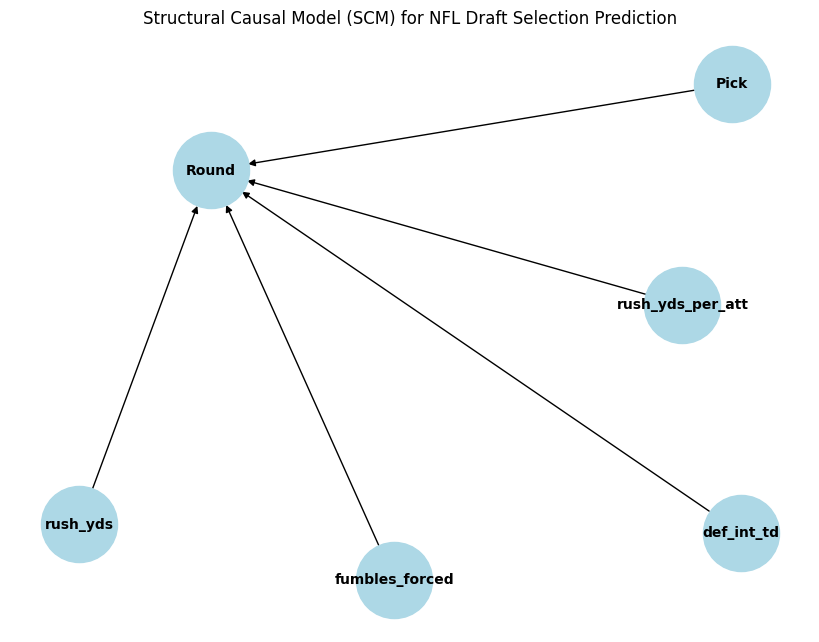

In [15]:
# Plot the causal graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", arrowstyle='-|>')
plt.title("Structural Causal Model (SCM) for NFL Draft Selection Prediction")
plt.show()